First, we will need to read the original _CSV_ and load it into a _DataFrame_

In [1]:
import pandas as pd

In [2]:
DATA_SOURCE = "./data/train.csv"
EXPORT_PATH = "./data/bolis-bic-anomaly.csv"

df = pd.read_csv(DATA_SOURCE)

In [3]:
df.head(10)

,date,temperature,light,airHumidity,humidity
0,2023-07-10 00:00:00,24.558222,0.0,72.278208,86.485813
1,2023-07-10 00:01:00,24.849800,0.0,72.191887,85.327090
2,2023-07-10 00:02:00,24.788302,0.0,70.960825,85.372835
3,2023-07-10 00:03:00,24.979886,0.0,71.424718,85.828448
4,2023-07-10 00:04:00,24.462985,0.0,71.010175,86.997323
5,2023-07-10 00:05:00,24.878799,0.0,70.465580,87.148065
6,2023-07-10 00:06:00,24.842049,0.0,71.056798,84.753346
7,2023-07-10 00:07:00,24.710550,0.0,71.726012,86.567493
8,2023-07-10 00:08:00,24.642757,0.0,71.006832,85.811375
9,2023-07-10 00:09:00,24.922215,0.0,71.220026,86.948260


In [4]:
df.describe()

,temperature,light,airHumidity,humidity
count,174360.000000,174360.000000,174360.000000,174360.000000
mean,21.610169,48.706657,69.459323,86.116717
std,3.427727,43.521437,4.954732,3.002257
min,10.857436,0.000000,49.691711,76.718130
25%,19.200176,0.000000,65.929197,84.139452
50%,21.580725,71.452690,69.974900,86.200328
75%,23.990309,90.388123,73.527058,87.881785
max,34.788918,100.000000,100.000000,100.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174360 entries, 0 to 174359
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         174360 non-null  object 
 1   temperature  174360 non-null  float64
 2   light        174360 non-null  float64
 3   airHumidity  174360 non-null  float64
 4   humidity     174360 non-null  float64
dtypes: float64(4), object(1)
memory usage: 6.7+ MB


Now that we have already loaded the dataset, we are going to look for the outliers. We have already seen that there are no NaN values, so we have to put in some work

In [6]:
import numpy as np
from scipy import stats

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
df_numerical = df.select_dtypes(include='number')

In [9]:
sns.set_theme()
sns.set(rc={'figure.figsize': (11.7, 8.27)})

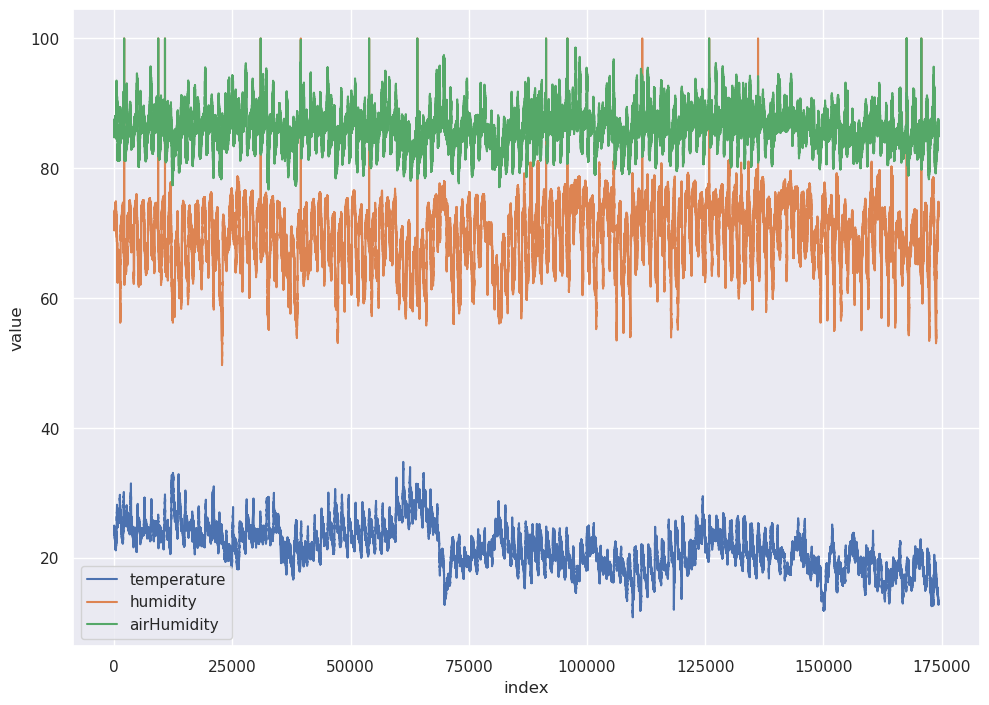

In [10]:
plt.plot(df_numerical.drop(columns=["light"]))
plt.legend(labels=["temperature", "humidity", "airHumidity"])
plt.xlabel('index')
plt.ylabel('value')
plt.show()

We removed the _light_ column because it had normal values [0, 1],  we can see that the _temperature_ column behaves pretty well, but the columns _humidity_ and _airHumidity_ tend to have some unusual highs. We can identify them as the troublesome variables

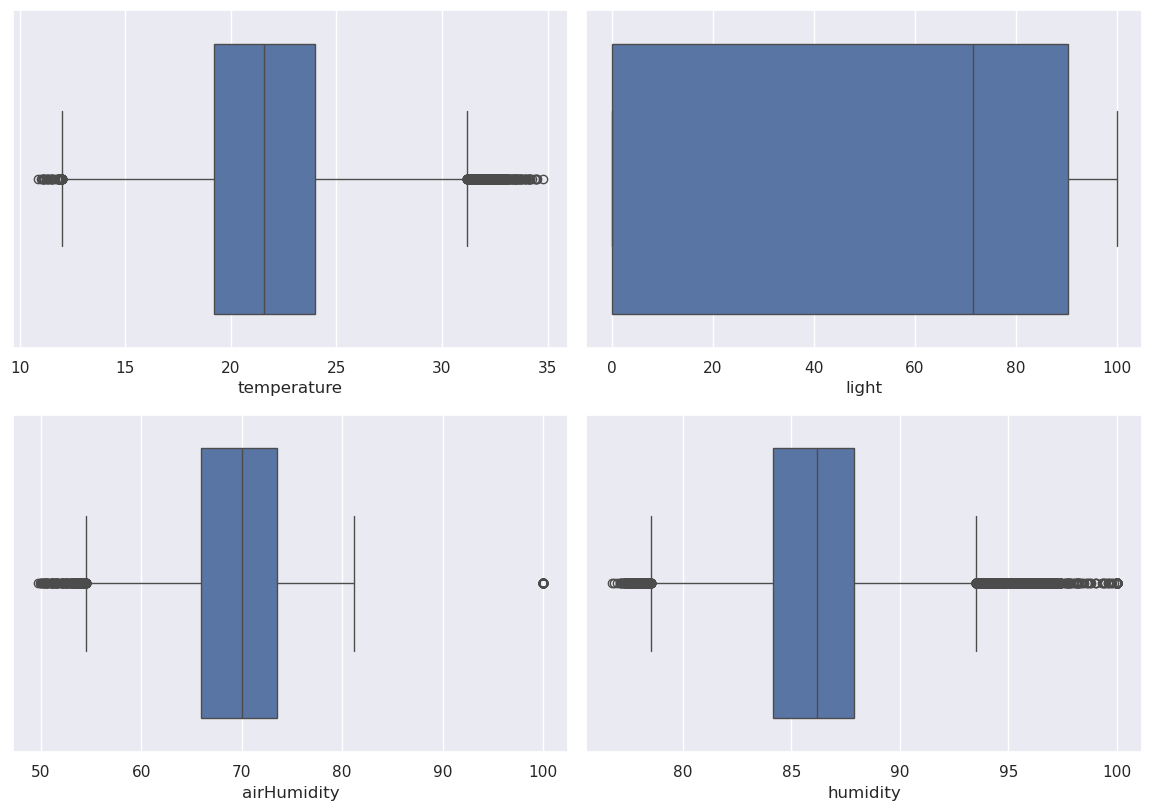

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2)

sns.boxplot(df, x='temperature', ax=axes[0][0])
sns.boxplot(df, x='light', ax=axes[0][1])
sns.boxplot(df, x='airHumidity', ax=axes[1][0])
sns.boxplot(df, x='humidity', ax=axes[1][1])

fig.tight_layout()

We can see that _humidity_ and _airHumidity_ contain a lot of outliers, most of which are in a small time lapse, as we saw in the raw graphic earlier. So, to remove them, instead of using the _zscore_ in the whole dataset, we can apply it in smaller groups of a _24 hour_ lapse. To do so, we only keep the _year/month/day_ values of the _date_ column and make smaller datasets by this column.

In [12]:
# Remove the hours
df["day"] = df["date"].apply(lambda date: date.split(" ")[0])

df.index = pd.to_datetime(df["date"])
df.set_index(df["date"])
df = df.drop(columns=["date"])

# Group dataframe by date
days = df["day"].unique()

df_dict = {elem: pd.DataFrame() for elem in days}
for key in df_dict.keys():
    df_dict[key] = df[:][df["day"] == key].drop(columns=["day"])

df_dict

{'2023-07-10':                      temperature  light  airHumidity   humidity
 date                                                           
 2023-07-10 00:00:00    24.558222    0.0    72.278208  86.485813
 2023-07-10 00:01:00    24.849800    0.0    72.191887  85.327090
 2023-07-10 00:02:00    24.788302    0.0    70.960825  85.372835
 2023-07-10 00:03:00    24.979886    0.0    71.424718  85.828448
 2023-07-10 00:04:00    24.462985    0.0    71.010175  86.997323
 ...                          ...    ...          ...        ...
 2023-07-10 23:55:00    25.945704    0.0    70.454291  84.687270
 2023-07-10 23:56:00    26.005410    0.0    71.329811  86.770481
 2023-07-10 23:57:00    25.848067    0.0    70.401883  84.459883
 2023-07-10 23:58:00    25.829457    0.0    69.753724  85.523071
 2023-07-10 23:59:00    26.139044    0.0    70.315743  85.264308
 
 [1440 rows x 4 columns],
 '2023-07-11':                      temperature  light  airHumidity   humidity
 date                             

In [13]:
df_clean = pd.DataFrame()
for key in df_dict.keys():
    curr_df = df_dict[key]
    
    # Separate outliers by their zscore
    not_outliers = curr_df[(np.abs(stats.zscore(curr_df)) < 3).all(axis=1)]
    outliers = curr_df.drop(not_outliers.index)

    # Apply interpolation in outliers weird columns (humidity & airHumidity)
    outliers["humidity"] = np.NaN
    outliers["airHumidity"] = np.NaN

    df_temp = pd.concat([not_outliers, outliers])
    df_temp.interpolate(inplace=True)
    
    df_clean = pd.concat([df_clean, df_temp])

df_clean.dropna(inplace=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174240 entries, 2023-07-10 00:00:00 to 2023-11-07 23:59:00
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  174240 non-null  float64
 1   light        174240 non-null  float64
 2   airHumidity  174240 non-null  float64
 3   humidity     174240 non-null  float64
dtypes: float64(4)
memory usage: 6.6 MB


In [14]:
print(f"Dropped rows: {len(df.index) - len(df_clean.index)}")

Dropped rows: 120


With this method of _zscoring_ "step by step" on the dataset, we only lose 120 rows of the data and we get the following final dataset:

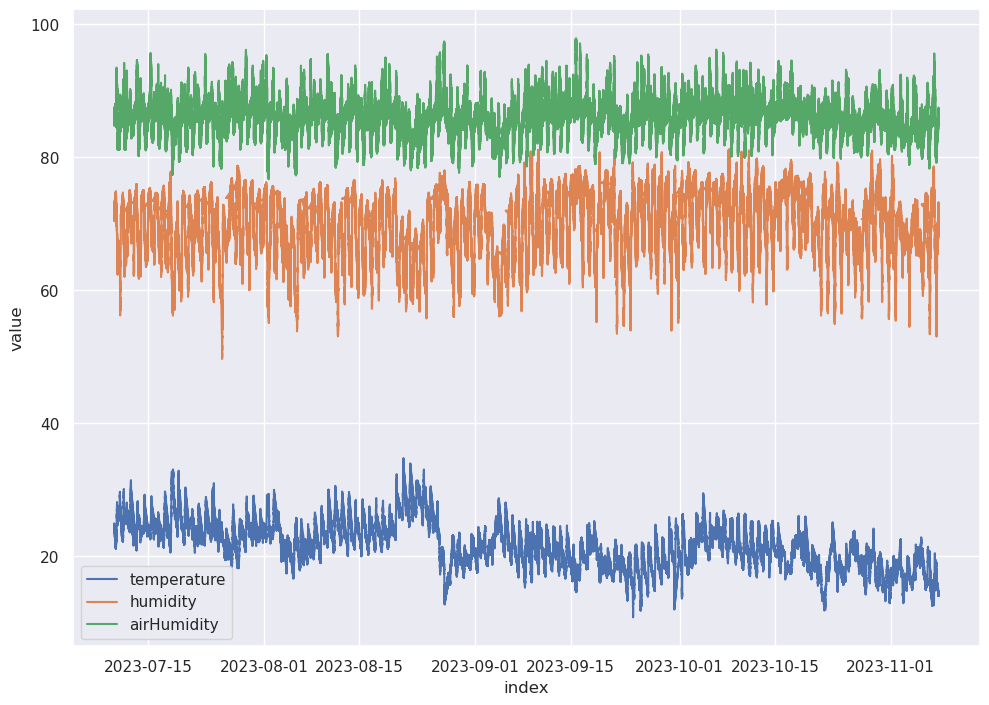

In [16]:
plt.plot(df_clean.drop(columns=["light"]))
plt.legend(labels=["temperature", "humidity", "airHumidity"])
plt.xlabel('index')
plt.ylabel('value')
plt.show()

In [17]:
df_clean.to_csv(EXPORT_PATH)